In [1]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 7.5 MB/s eta 0:00:00


In [2]:
#Libraries

import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from tld import get_tld
import os.path
import time
import plotly.express as px
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB


import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

# ***Loading the Dataset***

In [3]:
urldata = pd.read_csv("../input/malicious-url-detections/Malicious URLs detection.csv")
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [4]:
#Removing the unnamed columns as it is not necesary

urldata = urldata.drop('Unnamed: 0',axis=1)
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


# ***Introduction of dataset***

In [5]:
print('Dataset number of records: %s' % urldata.shape[0])
print('\nDataset number of columns: %s' % urldata.shape[1])

Dataset number of records: 450176

Dataset number of columns: 3


In [6]:
urldata["label"].value_counts()

benign       345738
malicious    104438
Name: label, dtype: int64

In [7]:
urldata.describe().T

,count,mean,std,min,25%,50%,75%,max
result,450176.0,0.231994,0.422105,0.0,0.0,0.0,0.0,1.0


In [8]:
urldata.isnull().sum()

url       0
label     0
result    0
dtype: int64

# ***DATA PREPROCESSING***

## ***Length Features***

        1. Length Of Url
        2. Length of Hostname
        3. Length Of Path
        4. Length Of First Directory
        5. Length Of Top Level Domain

In [9]:
#First Directory Length

def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

In [10]:
#Length of Top Level Domain
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

In [11]:
def len_preprocess(url_dataset):
    #Length of URL
    url_dataset['url_length'] = url_dataset['url'].apply(lambda i: len(str(i)))
    
    #Hostname Length
    url_dataset['hostname_length'] = url_dataset['url'].apply(lambda i: len(urlparse(i).netloc))
    
    #Path Length
    url_dataset['path_length'] = url_dataset['url'].apply(lambda i: len(urlparse(i).path))
    
    url_dataset['fd_length'] = url_dataset['url'].apply(lambda i: fd_length(i))
    url_dataset['tld'] = url_dataset['url'].apply(lambda i: get_tld(i,fail_silently=True))
    url_dataset['tld_length'] = url_dataset['tld'].apply(lambda i: tld_length(i))

In [12]:
len_preprocess(urldata)

In [13]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld,tld_length
0,https://www.google.com,benign,0,22,14,0,0,com,3
1,https://www.youtube.com,benign,0,23,15,0,0,com,3
2,https://www.facebook.com,benign,0,24,16,0,0,com,3
3,https://www.baidu.com,benign,0,21,13,0,0,com,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,org,3


In [14]:

urldata = urldata.drop("tld",1)

In [15]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length
0,https://www.google.com,benign,0,22,14,0,0,3
1,https://www.youtube.com,benign,0,23,15,0,0,3
2,https://www.facebook.com,benign,0,24,16,0,0,3
3,https://www.baidu.com,benign,0,21,13,0,0,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,3


## ***Count Features***

        1. Count Of '-'
        2. Count Of '@'
        3. Count Of '?'
        4. Count Of '%'
        5. Count Of '.'
        6. Count Of '='
        7. Count Of 'http'
        8. Count Of 'www'
        9. Count Of Digits
        10.Count Of Letters
        11.Count Of Number Of Directories


In [16]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [17]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [18]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

In [19]:
def count_preprocess(url_dataset):
    url_dataset['count_dir'] = url_dataset['url'].apply(lambda i: no_of_dir(i))
    url_dataset['count-letters']= url_dataset['url'].apply(lambda i: letter_count(i))
    url_dataset['count-digits']= url_dataset['url'].apply(lambda i: digit_count(i))
    url_dataset['count-www'] = url_dataset['url'].apply(lambda i: i.count('www'))
    url_dataset['count-https'] = url_dataset['url'].apply(lambda i : i.count('https'))
    url_dataset['count-http'] = url_dataset['url'].apply(lambda i : i.count('http'))
    url_dataset['count='] = url_dataset['url'].apply(lambda i: i.count('='))
    url_dataset['count.'] = url_dataset['url'].apply(lambda i: i.count('.'))
    url_dataset['count%'] = url_dataset['url'].apply(lambda i: i.count('%'))
    url_dataset['count?'] = url_dataset['url'].apply(lambda i: i.count('?'))
    url_dataset['count@'] = url_dataset['url'].apply(lambda i: i.count('@'))
    url_dataset['count-'] = url_dataset['url'].apply(lambda i: i.count('-'))

In [20]:

count_preprocess(urldata)

In [21]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count_dir,count-letters,count-digits,count-www,count-https,count-http,count=,count.,count%,count?,count@,count-
0,https://www.google.com,benign,0,22,14,0,0,3,0,17,0,1,1,1,0,2,0,0,0,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,18,0,1,1,1,0,2,0,0,0,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,19,0,1,1,1,0,2,0,0,0,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,16,0,1,1,1,0,2,0,0,0,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,20,0,1,1,1,0,2,0,0,0,0


## ***Binary Features***

    1. Use of IP or not
    2. Use of Shortening URL or not

In [22]:
#Use of IP or not in domain

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1

In [23]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1

In [24]:
def ip_process(url_dataset):
    url_dataset['short_url'] = url_dataset['url'].apply(lambda i: shortening_service(i))
    url_dataset['use_of_ip'] = url_dataset['url'].apply(lambda i: having_ip_address(i))

In [25]:
ip_process(urldata)

In [26]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count_dir,count-letters,...,count-https,count-http,count=,count.,count%,count?,count@,count-,short_url,use_of_ip
0,https://www.google.com,benign,0,22,14,0,0,3,0,17,...,1,1,0,2,0,0,0,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,18,...,1,1,0,2,0,0,0,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,19,...,1,1,0,2,0,0,0,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,16,...,1,1,0,2,0,0,0,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,20,...,1,1,0,2,0,0,0,0,1,1


# ***Data Visualization***

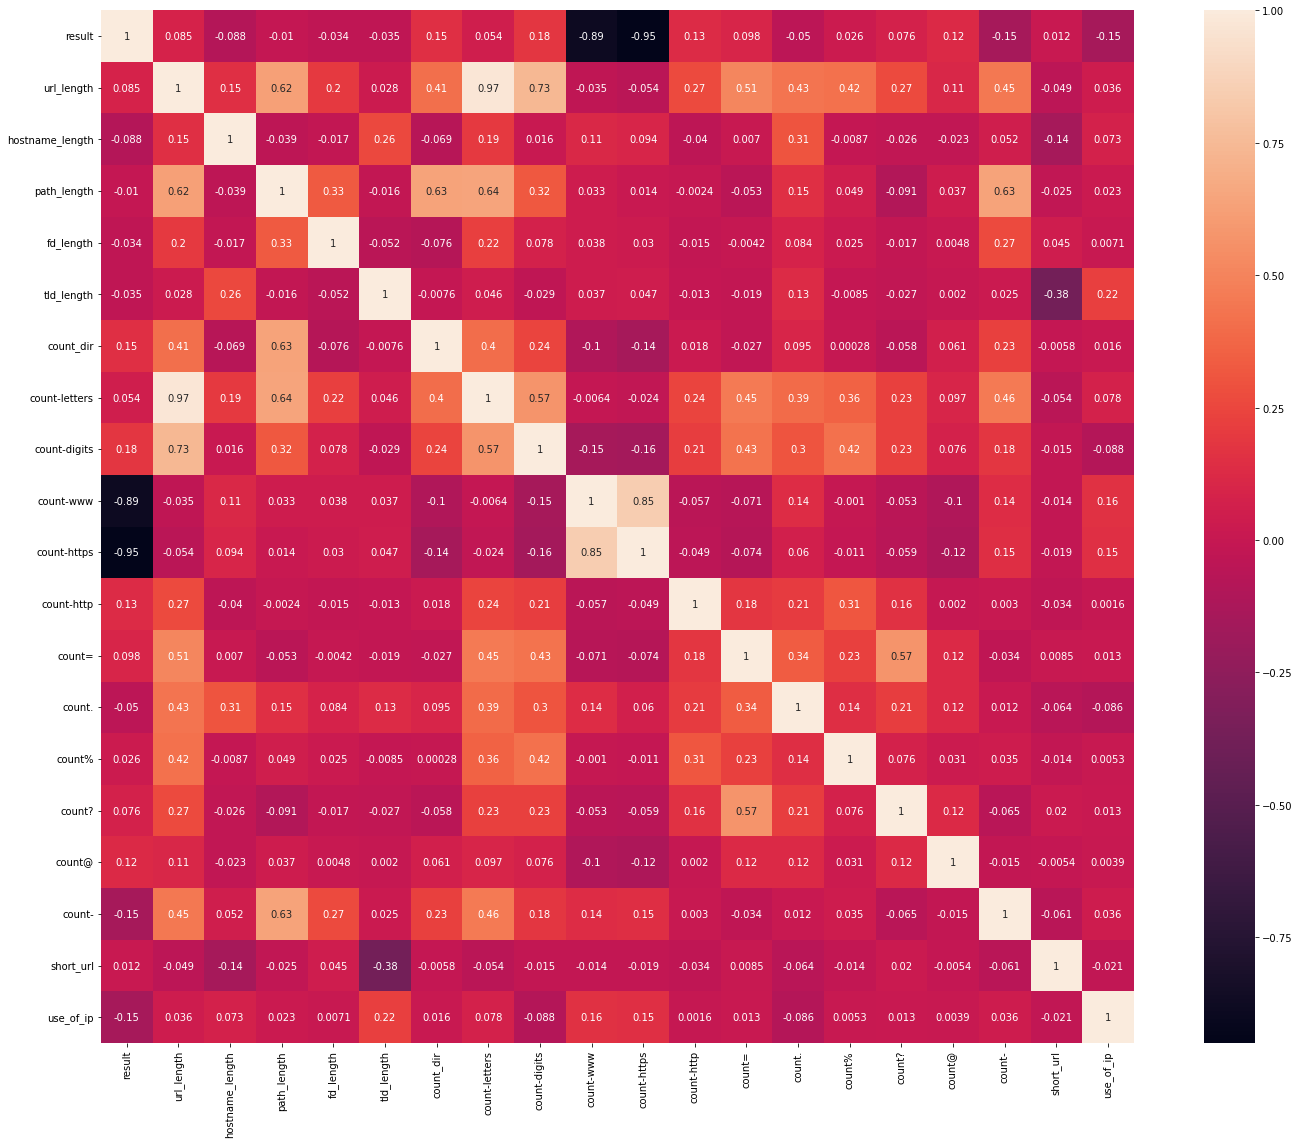

In [27]:
#Heatmap

corrmat = urldata.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

plt.savefig("heatmap.png")

Text(0, 0.5, 'Number Of URLs')

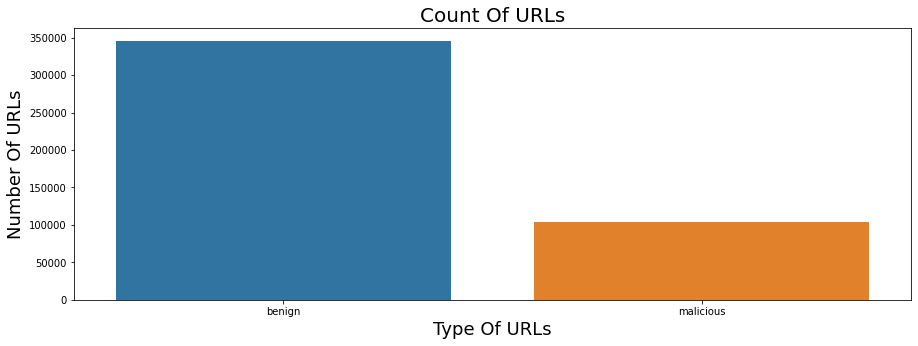

In [28]:
plt.figure(figsize=(15,5))
sns.countplot(x='label',data=urldata)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

In [29]:
print("Percent Of Malicious URLs:{:.2f} %".format(len(urldata[urldata['label']=='malicious'])/len(urldata['label'])*100))
print("Percent Of Benign URLs:{:.2f} %".format(len(urldata[urldata['label']=='benign'])/len(urldata['label'])*100))

Percent Of Malicious URLs:23.20 %
Percent Of Benign URLs:76.80 %


(0.0, 1000.0)

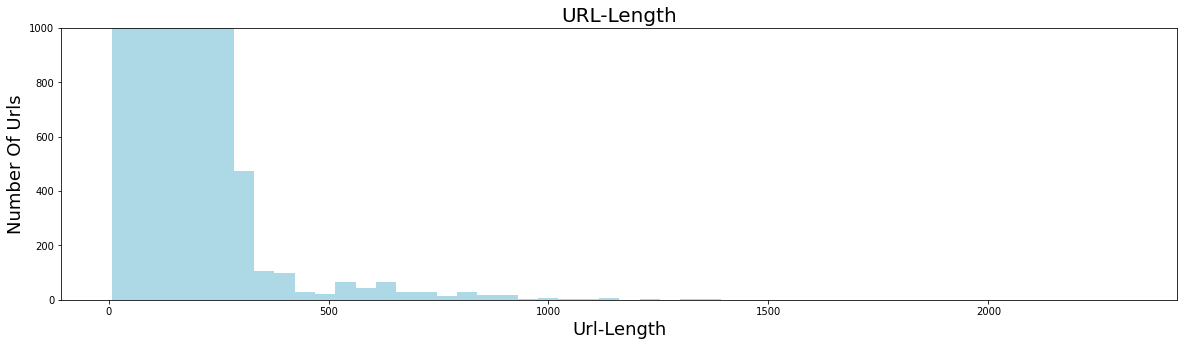

In [30]:
plt.figure(figsize=(20,5))
plt.hist(urldata['url_length'],bins=50,color='LightBlue')
plt.title("URL-Length",fontsize=20)
plt.xlabel("Url-Length",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

(0.0, 1000.0)

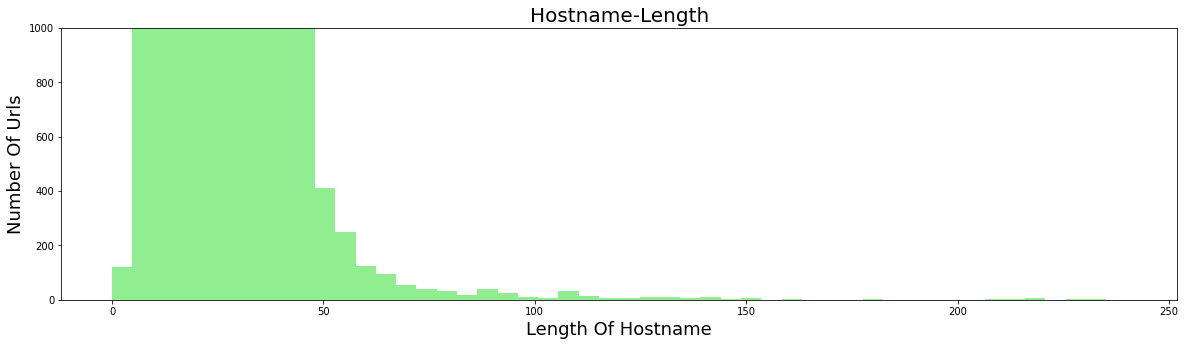

In [31]:
plt.figure(figsize=(20,5))
plt.hist(urldata['hostname_length'],bins=50,color='Lightgreen')
plt.title("Hostname-Length",fontsize=20)
plt.xlabel("Length Of Hostname",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

Text(0, 0.5, 'Number Of URLs')

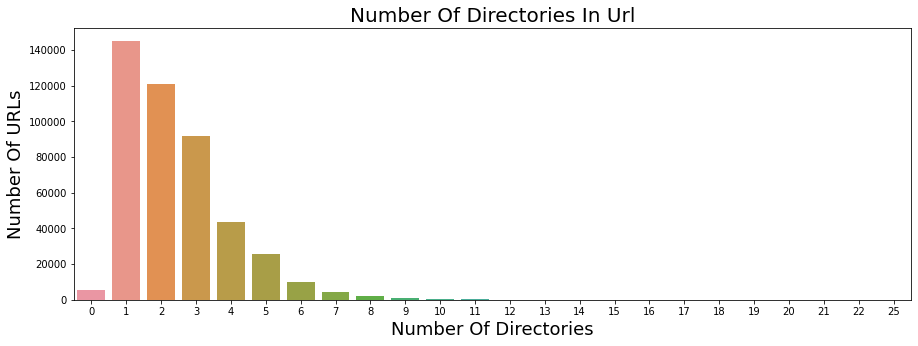

In [32]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata)
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

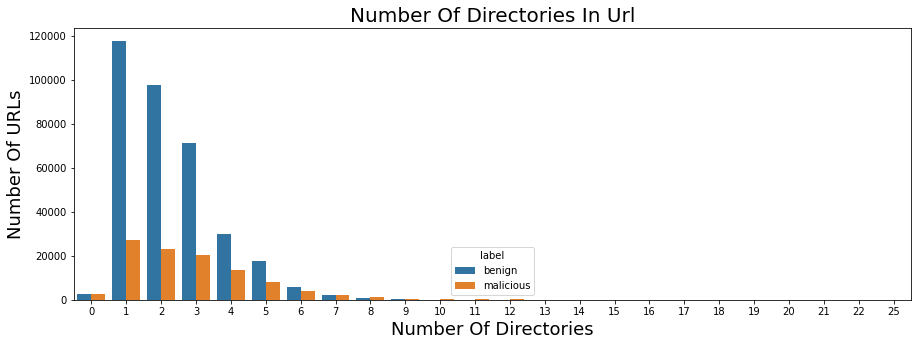

In [33]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata,hue='label')
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

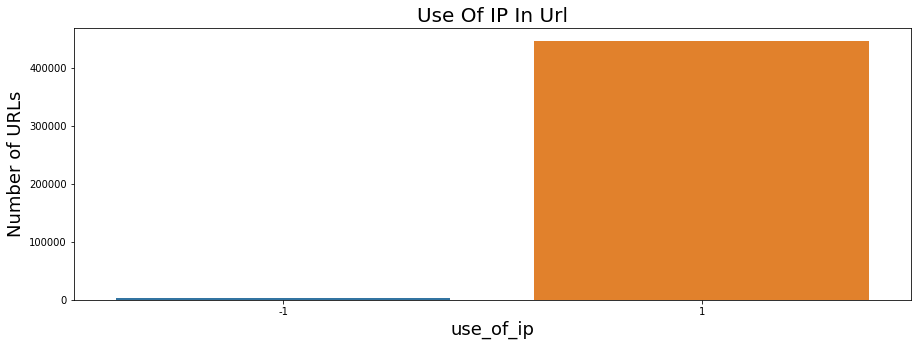

In [34]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)

sns.countplot(urldata['use_of_ip'])
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

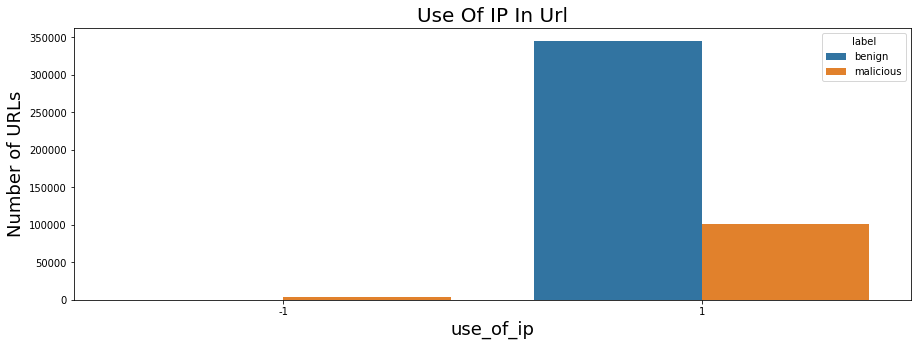

In [35]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
sns.countplot(urldata['use_of_ip'],hue='label',data=urldata)
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

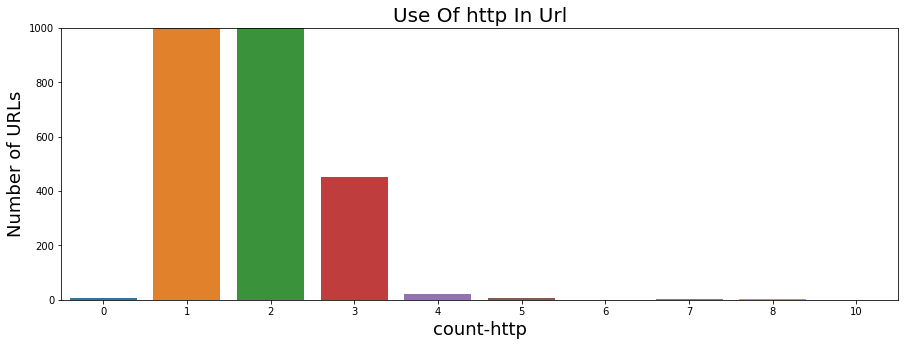

In [36]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'])
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

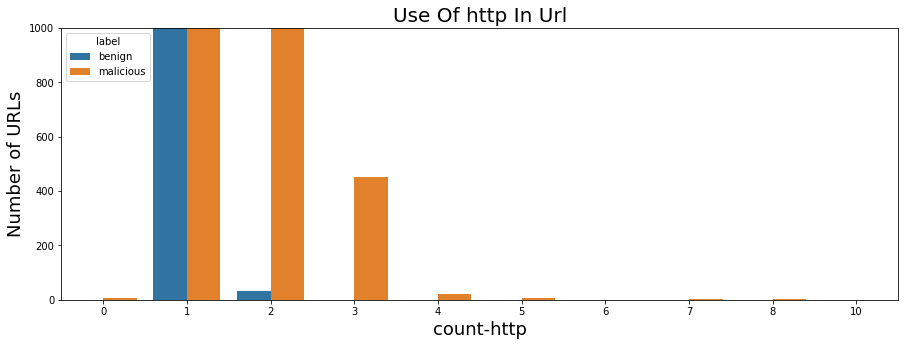

In [37]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count Of http",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'],hue='label',data=urldata)
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

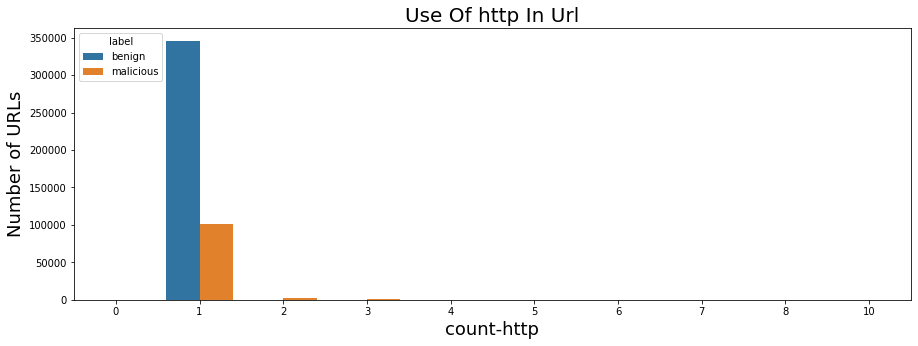

In [38]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count Of http",fontsize=18)

sns.countplot(urldata['count-http'],hue='label',data=urldata)

plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

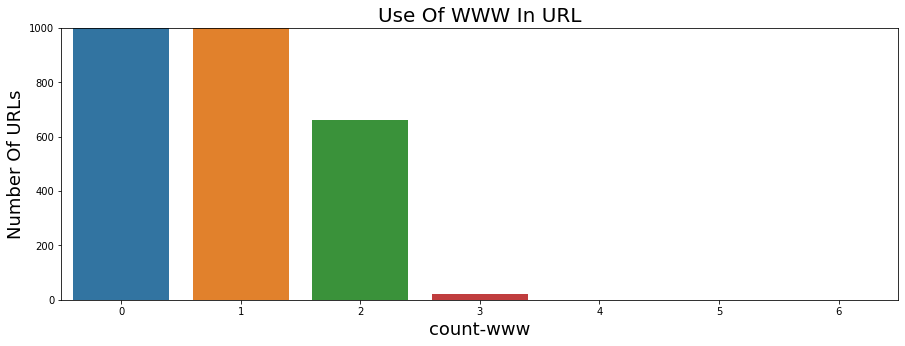

In [39]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)
sns.countplot(urldata['count-www'])
plt.ylim(0,1000)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

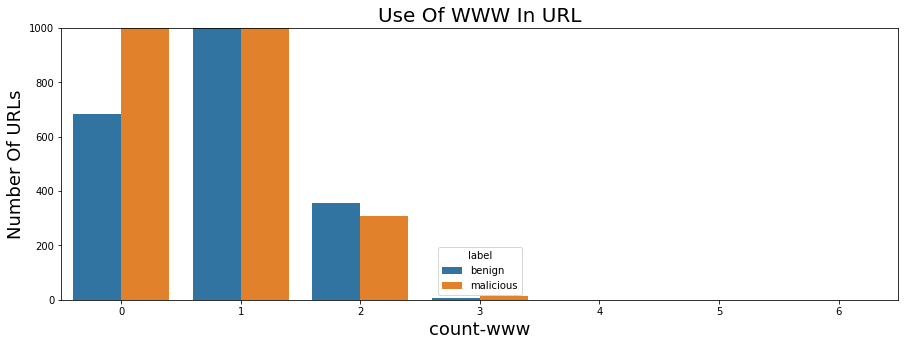

In [40]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)

sns.countplot(urldata['count-www'],hue='label',data=urldata)
plt.ylim(0,1000)
plt.ylabel("Number Of URLs",fontsize=18)

# ***Building Models***

In [41]:
#Predictor Variables

x = urldata[['hostname_length',
       'path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

In [42]:
#Target Variable
y = urldata['result']

In [43]:
x.shape

(450176, 17)

In [44]:
y.shape

(450176,)

In [45]:
#Splitting the data into Training and Testing

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3, random_state=42)

In [46]:
model_accuracy = {}

In [47]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv):
    _scoring = ['accuracy']
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
    print("Training Accuracy scores", results['train_accuracy']*100)
    print("\nMean Training Accuracy", results['train_accuracy'].mean()*100)
    print("\nValidation Accuracy scores", results['test_accuracy'])
    print("\nMean Validation Accuracy", results['test_accuracy'].mean()*100)

    
      
#     return {"Training Accuracy scores": results['train_accuracy'],
#               "Mean Training Accuracy": results['train_accuracy'].mean()*100,
#               "Training Precision scores": results['train_precision'],
#               "Mean Training Precision": results['train_precision'].mean(),
#               "Training Recall scores": results['train_recall'],
#               "\nMean Training Recall": results['train_recall'].mean(),
#               "\nTraining F1 scores": results['train_f1'],
#               "\nMean Training F1 Score": results['train_f1'].mean(),
#               "\nValidation Accuracy scores": results['test_accuracy'],
#               "\nMean Validation Accuracy": results['test_accuracy'].mean()*100,
#               "\nValidation Precision scores": results['test_precision'],
#               "\nMean Validation Precision": results['test_precision'].mean(),
#               "\nValidation Recall scores": results['test_recall'],
#               "\nMean Validation Recall": results['test_recall'].mean(),
#               "\nValidation F1 scores": results['test_f1'],
#               "\nMean Validation F1 Score": results['test_f1'].mean()
              

## 1. Logistic Regression
 

In [48]:
%%time

log_reg_model = LogisticRegression()
log_reg_model.fit(x_train,y_train)

log_reg_predictions = log_reg_model.predict(x_test)


print(accuracy_score(y_test, log_reg_predictions), "\n\n\n")

0.9957730924969218 



CPU times: user 3.11 s, sys: 948 ms, total: 4.05 s
Wall time: 2.07 s


In [49]:
# x_test

In [50]:
# y_test

In [51]:
# print(confusion_matrix(y_test,log_reg_model))

Training Accuracy : 0.9959571128158042
Testing Accuracy : 0.9957730924969218

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00    242154
        Good       0.99      0.99      0.99     72970

    accuracy                           1.00    315124
   macro avg       0.99      0.99      0.99    315124
weighted avg       1.00      1.00      1.00    315124


CONFUSION MATRIX


<AxesSubplot:>

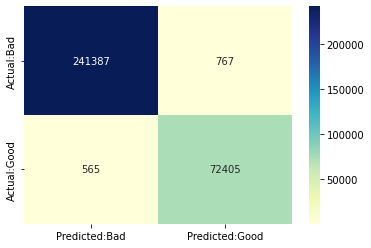

In [52]:
print('Training Accuracy :',log_reg_model.score(x_train,y_train))
print('Testing Accuracy :',log_reg_model.score(x_test,y_test))

con_mat = pd.DataFrame(confusion_matrix(log_reg_model.predict(x_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(log_reg_model.predict(x_test), y_test,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [53]:
model_accuracy['Logistic Regression'] = log_reg_model.score(x_test,y_test)

In [54]:
pickle.dump(log_reg_model, open('Model_det_LR.pkl', 'wb'))

In [55]:
cross_validation(log_reg_model, x_train,y_train, 10)

Training Accuracy scores [99.59192405 99.59603771 99.57218195 99.59439558 99.59933195 99.60426831
 99.59933195 99.59686376 99.60180013 99.60180013]

Mean Training Accuracy 99.59579355143424

Validation Accuracy scores [0.99681623 0.99548349 0.99592743 0.99622362 0.99585339 0.9955572
 0.99577934 0.99614957 0.99592743 0.99563125]

Mean Validation Accuracy 99.59348959665408


## 2. Decision Tree

In [56]:
%%time

dt_model = DecisionTreeClassifier()
dt_model.fit(x_train,y_train)

dt_predictions = dt_model.predict(x_test)

print(accuracy_score(y_test, dt_predictions), "\n\n\n")

0.995293916045747 



CPU times: user 1.03 s, sys: 935 µs, total: 1.04 s
Wall time: 1.03 s


In [57]:
# print(confusion_matrix(y_test,dt_predictions))

Training Accuracy : 0.9995187039066433
Testing Accuracy : 0.995293916045747

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00    241897
        Good       0.99      0.99      0.99     73227

    accuracy                           1.00    315124
   macro avg       0.99      0.99      0.99    315124
weighted avg       1.00      1.00      1.00    315124


CONFUSION MATRIX


<AxesSubplot:>

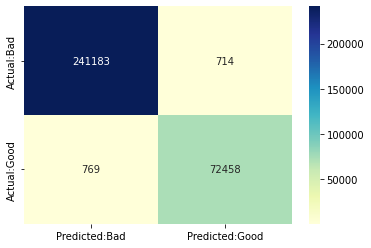

In [58]:
print('Training Accuracy :',dt_model.score(x_train,y_train))
print('Testing Accuracy :',dt_model.score(x_test,y_test))

con_mat = pd.DataFrame(confusion_matrix(dt_model.predict(x_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(dt_model.predict(x_test), y_test,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [59]:
model_accuracy['Decision Tree'] = dt_model.score(x_test,y_test)

In [60]:
cross_validation(dt_model, x_train,y_train, 10)

Training Accuracy scores [99.95063597 99.95063597 99.95392729 99.94981365 99.95310456 99.95392729
 99.95557274 99.95145911 99.9572182  99.95310456]

Mean Training Accuracy 99.95293993374742

Validation Accuracy scores [0.99563157 0.99592774 0.99570529 0.99622362 0.99489078 0.99548315
 0.99533506 0.99585339 0.99533506 0.99511292]

Mean Validation Accuracy 99.55498588722179


## 3. Random Forest

In [61]:
%%time

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_predictions = rfc.predict(x_test)
accuracy_score(y_test, rfc_predictions)


print(accuracy_score(y_test, rfc_predictions), "\n\n\n")

0.997274088930072 



CPU times: user 24.4 s, sys: 23.5 ms, total: 24.5 s
Wall time: 24.5 s


In [62]:
# print(confusion_matrix(y_test,rfc_predictions))

Training Accuracy : 0.9995187039066433
Testing Accuracy : 0.997274088930072

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00    242249
        Good       0.99      1.00      0.99     72875

    accuracy                           1.00    315124
   macro avg       1.00      1.00      1.00    315124
weighted avg       1.00      1.00      1.00    315124


CONFUSION MATRIX


<AxesSubplot:>

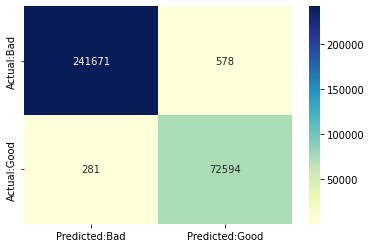

In [63]:
print('Training Accuracy :',rfc.score(x_train,y_train))
print('Testing Accuracy :',rfc.score(x_test,y_test))

con_mat = pd.DataFrame(confusion_matrix(rfc.predict(x_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(rfc.predict(x_test), y_test,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [64]:
model_accuracy['Random Forest'] = rfc.score(x_test,y_test)

In [65]:
cross_validation(rfc, x_train,y_train, 10)

Training Accuracy scores [99.95063597 99.95063597 99.95392729 99.94981365 99.95310456 99.95392729
 99.95557274 99.95145911 99.9572182  99.95228183]

Mean Training Accuracy 99.95285766104631

Validation Accuracy scores [0.9974826  0.99726048 0.99763051 0.99763051 0.99726027 0.99726027
 0.99689004 0.99733432 0.99711218 0.99659385]

Mean Validation Accuracy 99.72455035684773


## 4. Support Vector Classifier

In [66]:
%%time

svc = SVC(kernel='linear')

svc.fit(x_train, y_train) 
svc_prediction = svc.predict(x_test)



print(accuracy_score(y_test, svc_prediction),"\n\n\n" )


0.9966172046559449 



CPU times: user 5min 1s, sys: 390 ms, total: 5min 1s
Wall time: 5min 3s


Training Accuracy : 0.9966309273465036
Testing Accuracy : 0.9966172046559449

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00    242000
        Good       0.99      0.99      0.99     73124

    accuracy                           1.00    315124
   macro avg       1.00      1.00      1.00    315124
weighted avg       1.00      1.00      1.00    315124


CONFUSION MATRIX


<AxesSubplot:>

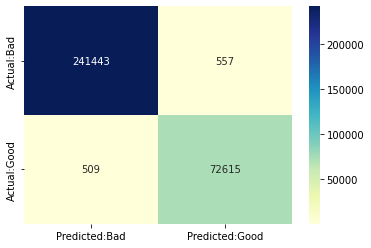

In [67]:
print('Training Accuracy :',svc.score(x_train,y_train))
print('Testing Accuracy :',svc.score(x_test,y_test))

con_mat = pd.DataFrame(confusion_matrix(svc.predict(x_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(svc.predict(x_test), y_test,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [68]:
model_accuracy['Support Vector Classifier'] = svc.score(x_test,y_test)

In [69]:
cross_validation(svc, x_train,y_train, 10)

Training Accuracy scores [99.65362908 99.65938822 99.65445466 99.65363193 99.66432738 99.66597283
 99.66432738 99.66268193 99.66103647 99.66761829]

Mean Training Accuracy 99.66070681548477

Validation Accuracy scores [0.99696431 0.99644602 0.99740837 0.99696409 0.99651981 0.99637171
 0.99651981 0.99614957 0.99629767 0.99622362]

Mean Validation Accuracy 99.65864982574149


## 5. Gaussian Naive Bayes classifier

In [70]:
%%time

gnb = GaussianNB()

gnb.fit(x_train, y_train) 

gnb_prediction = gnb.predict(x_test)
print(accuracy_score(y_test, gnb_prediction), "\n\n\n")

0.9914605044363488 



CPU times: user 134 ms, sys: 39 ms, total: 173 ms
Wall time: 172 ms


Training Accuracy : 0.9916920889731363
Testing Accuracy : 0.9914605044363488

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.99      1.00      0.99    240203
        Good       0.99      0.97      0.98     74921

    accuracy                           0.99    315124
   macro avg       0.99      0.98      0.99    315124
weighted avg       0.99      0.99      0.99    315124


CONFUSION MATRIX


<AxesSubplot:>

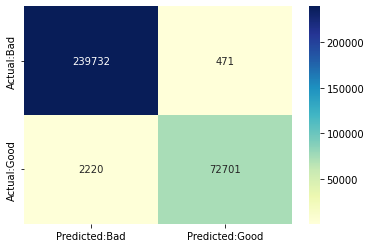

In [71]:
print('Training Accuracy :',gnb.score(x_train,y_train))
print('Testing Accuracy :',gnb.score(x_test,y_test))

con_mat = pd.DataFrame(confusion_matrix(gnb.predict(x_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(gnb.predict(x_test), y_test,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [72]:
model_accuracy['Gaussian Naive Bayes'] = gnb.score(x_test,y_test)

In [73]:
cross_validation(gnb, x_train,y_train, 10)

Training Accuracy scores [99.15752061 99.18631629 99.17315935 99.17562754 99.16081845 99.16657754
 99.17233663 99.17480481 99.15259118 99.14765482]

Mean Training Accuracy 99.16674072073923

Validation Accuracy scores [0.9920776  0.99037465 0.99192892 0.99192892 0.9922251  0.99215106
 0.99118845 0.9923732  0.99104036 0.99141059]

Mean Validation Accuracy 99.16698818789824


# ***Model Compression***

In [74]:
model_accuracy

{'Logistic Regression': 0.9957730924969218,
 'Decision Tree': 0.995293916045747,
 'Random Forest': 0.997274088930072,
 'Support Vector Classifier': 0.9966172046559449,
 'Gaussian Naive Bayes': 0.9914605044363488}

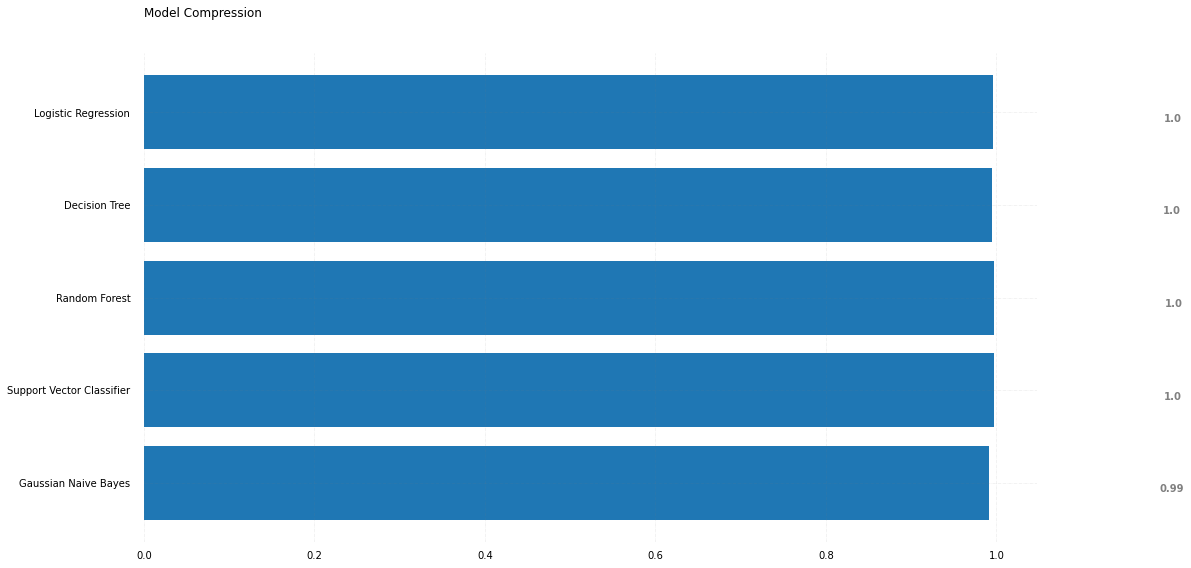

In [75]:
models = list(model_accuracy.keys())
acc_score = list(model_accuracy.values())

#fig = plt.figure(figsize = (10, 15))

# plt.bar(models,acc_score, width = 0.4)
# plt.title("Models compression")
# plt.xlabel("Models")
# plt.ylabel("Accuracy score")
# plt.show()


# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(models, acc_score)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Model Compression\n\n',loc ='left', )
 
# Show Plot
plt.show()


# ***Predicton***

In [76]:
def pred(link):
    loaded_model = pickle.load(open('./Model_det_LR.pkl', 'rb'))
    
    sample =[]
    sample.append(link)
    df = pd.DataFrame(sample, columns=['url'])
    len_preprocess(df)
    df = df.drop("tld",1)
    count_preprocess(df)
    ip_process(df)
    df = df[['hostname_length',
       'path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]
    result = loaded_model.predict(df)
    if result[0] == 0:
        print("benign")
    else:
        print("Phishing")


In [77]:
# link = input("Enter your link:\t")

link = "www.youtube.com"
pred(link)

benign


In [78]:
link = "svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt"
pred(link)

Phishing
